In [202]:
# our basic libraries
import torch
import torchvision

# data loading and transforming
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader
from torchvision import transforms

# The output of torchvision datasets are PILImage images of range [0, 1]. 
# We transform them to Tensors for input into a CNN

## Define a transform to read the data in as a tensor
data_transform = transforms.ToTensor()

# choose the training and test datasets
train_data = FashionMNIST(root='./data', train=True,
                                   download=True, transform=data_transform)

test_data = FashionMNIST(root='./data', train=False,
                                  download=True, transform=data_transform)


# Print out some stats about the training and test data
print('Train data, number of images: ', len(train_data))
print('Test data, number of images: ', len(test_data))

Train data, number of images:  60000
Test data, number of images:  10000


In [203]:
# prepare data loaders, set the batch_size
## TODO: you can try changing the batch_size to be larger or smaller
## when you get to training your network, see how batch_size affects the loss
batch_size = 64

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

# specify the image classes
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

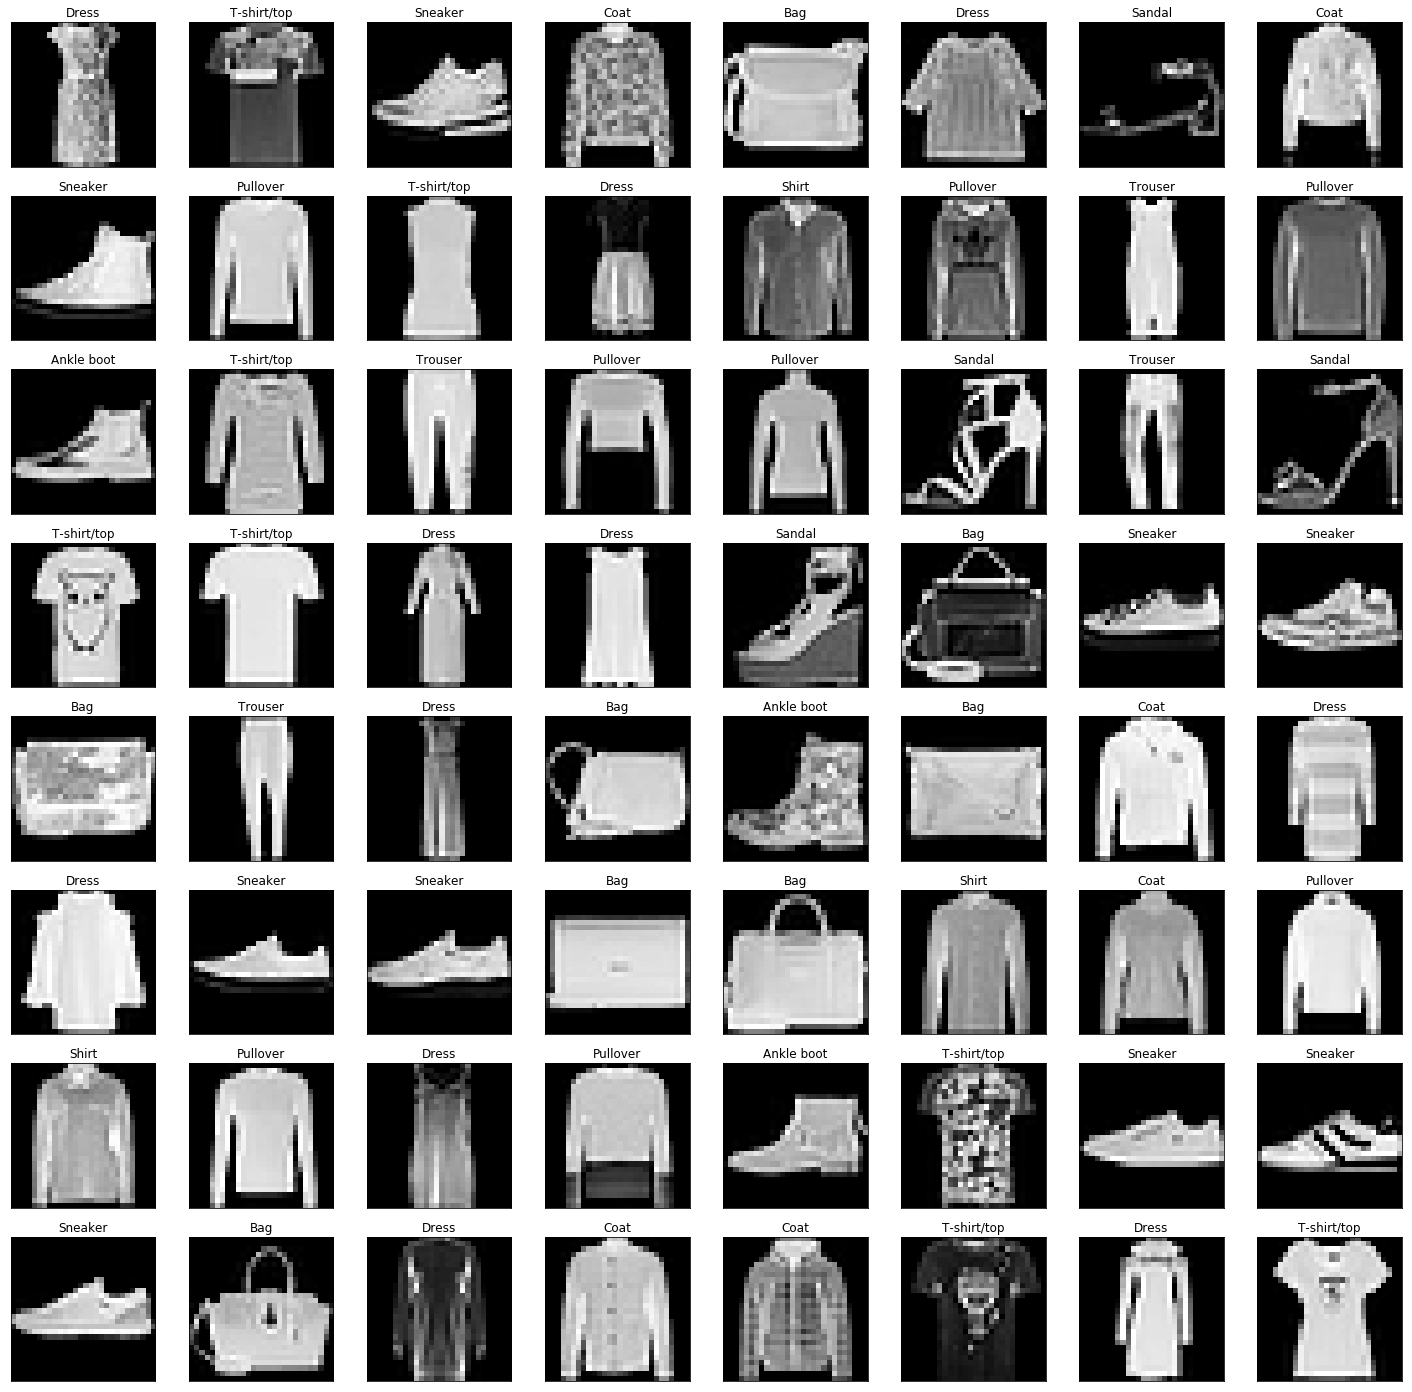

In [204]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 25))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(8, batch_size/8, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title(classes[labels[idx]])

Sneaker


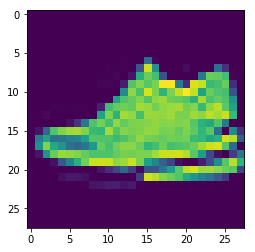

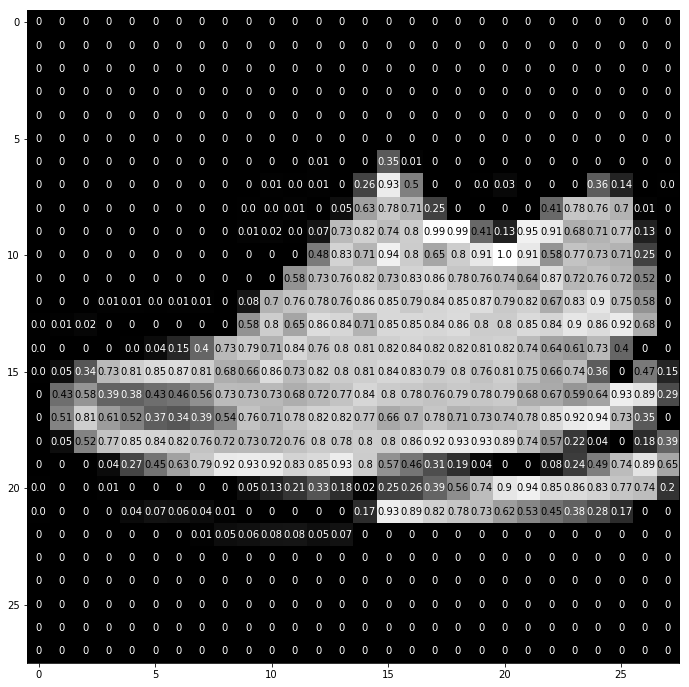

In [205]:
# select an image by index
idx = 2
img = np.squeeze(images[idx])
print(classes[labels[idx]])
plt.imshow(img)
# display the pixel values in that image
fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')

In [241]:
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
torch.set_default_tensor_type('torch.FloatTensor')

class Net(nn.Module):

    def __init__(self, input_size, output_size, conv_layers, fc_layers, dropout_p):
        super(Net, self).__init__()
        
        # 1 input image channel (grayscale), 10 output channels/feature maps
        # 3x3 square convolution kernel
        self.conv_size = len(conv_layers)
        self.conv_layers = nn.ModuleList([nn.Conv2d(input_size, conv_layers[0], 3)]) 
        conv_sizes = zip(conv_layers[:-1], conv_layers[1:])
        self.conv_layers.extend([nn.Conv2d(h1, h2, 3) for h1, h2 in conv_sizes])
        
        self.bn_layers = nn.ModuleList([])
        self.bn_layers.extend([nn.BatchNorm2d(s) for s in conv_layers])
        #self.fully_layers = nn.ModuleList([nn.Linear()])
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout2d(p=dropout_p)
        self.fc = nn.Linear(3200, fc_layers[0])
        self.output = nn.Linear(fc_layers[0], output_size)
        self.fc_drop = nn.Dropout(p=0.4)
    ## TODO: define the feedforward behavior
    def forward(self, x):
        
        for i in range(self.conv_size):
            conv = self.conv_layers[i]
            bn = self.bn_layers[i]
            x = self.pool(F.relu(bn(conv(x))))
            x = self.dropout(x)
        x = x.view(x.size()[0], -1)
        x = self.fc(x)
        x = self.fc_drop(x)
        x = self.output(x)
        return F.log_softmax(x, dim=1)
# instantiate and print your Net
net = Net(1, 10, [64,128],[512],0.2)
net.cuda()
print(net)

Net(
  (conv_layers): ModuleList(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  )
  (bn_layers): ModuleList(
    (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout2d(p=0.2)
  (fc): Linear(in_features=3200, out_features=512, bias=True)
  (output): Linear(in_features=512, out_features=10, bias=True)
  (fc_drop): Dropout(p=0.4)
)


In [242]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
#net = net.cuda()

In [243]:
epochs = 3
steps = 0
running_loss = 0
print_every = 40
for e in range(epochs):
    # Model in training mode, dropout is on
    net.train()
    for images, labels in iter(train_loader):
        steps += 1
        # Flatten images into a 784 long vector
        
        # Wrap images and labels in Variables so we can calculate gradients
        inputs = Variable(images)
        targets = Variable(labels)
        inputs, targets = inputs.cuda(), targets.cuda()
        optimizer.zero_grad()
        
        output = net.forward(inputs)
        loss = criterion(output, targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.data[0]
        
        if steps % print_every == 0:
            # Model in inference mode, dropout is off
            net.eval()
            
            accuracy = 0
            test_loss = 0
            for ii, (images, labels) in enumerate(test_loader):
                
                #images = images.resize_(images.size()[0], 784)
                with torch.no_grad():
                    # Set volatile to True so we don't save the history
                    inputs = Variable(images, volatile=True)
                    labels = Variable(labels, volatile=True)
                    inputs, labels = inputs.cuda(), labels.cuda()
                    output = net.forward(inputs)
                    test_loss += criterion(output, labels).data[0]

                    ## Calculating the accuracy 
                    # Model's output is log-softmax, take exponential to get the probabilities
                    ps = torch.exp(output).data
                    # Class with highest probability is our predicted class, compare with true label
                    equality = (labels.data == ps.max(1)[1])
                    # Accuracy is number of correct predictions divided by all predictions, just take the mean
                    accuracy += equality.type_as(torch.FloatTensor()).mean()
            
            print("Epoch: {}/{}.. ".format(e+1, epochs),
                  "Training Loss: {:.3f}.. ".format(running_loss/print_every),
                  "Test Loss: {:.3f}.. ".format(test_loss/len(test_loader)),
                  "Test Accuracy: {:.3f}".format(accuracy/len(test_loader)))
            
            running_loss = 0
            
            # Make sure dropout is on for training
            net.train()

C:\Users\lobov\Anaconda3\envs\tfgpu\lib\site-packages\ipykernel_launcher.py:23: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
C:\Users\lobov\Anaconda3\envs\tfgpu\lib\site-packages\ipykernel_launcher.py:36: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
C:\Users\lobov\Anaconda3\envs\tfgpu\lib\site-packages\ipykernel_launcher.py:37: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
C:\Users\lobov\Anaconda3\envs\tfgpu\lib\site-packages\ipykernel_launcher.py:40: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch: 1/3..  Training Loss: 1.146..  Test Loss: 0.707..  Test Accuracy: 0.745
Epoch: 1/3..  Training Loss: 0.706..  Test Loss: 0.560..  Test Accuracy: 0.796
Epoch: 1/3..  Training Loss: 0.582..  Test Loss: 0.544..  Test Accuracy: 0.809
Epoch: 1/3..  Training Loss: 0.625..  Test Loss: 0.610..  Test Accuracy: 0.800
Epoch: 1/3..  Training Loss: 0.542..  Test Loss: 0.473..  Test Accuracy: 0.834
Epoch: 1/3..  Training Loss: 0.513..  Test Loss: 0.503..  Test Accuracy: 0.814
Epoch: 1/3..  Training Loss: 0.506..  Test Loss: 0.461..  Test Accuracy: 0.832
Epoch: 1/3..  Training Loss: 0.502..  Test Loss: 0.440..  Test Accuracy: 0.841
Epoch: 1/3..  Training Loss: 0.479..  Test Loss: 0.412..  Test Accuracy: 0.852
Epoch: 1/3..  Training Loss: 0.437..  Test Loss: 0.398..  Test Accuracy: 0.857
Epoch: 1/3..  Training Loss: 0.438..  Test Loss: 0.406..  Test Accuracy: 0.855
Epoch: 1/3..  Training Loss: 0.430..  Test Loss: 0.432..  Test Accuracy: 0.844
Epoch: 1/3..  Training Loss: 0.438..  Test Loss: 0.4

In [244]:
# initialize tensor and lists to monitor test loss and accuracy
test_loss = torch.zeros(1)
test_loss = test_loss.cuda()
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

# set the module to evaluation mode
net.eval()
total_correct = 0
for batch_i, data in enumerate(test_loader):
    
    # get the input images and their corresponding labels
    inputs, labels = data
    with torch.no_grad():
        # wrap them in a torch Variable
        # volatile means we do not have to track how the inputs change
        inputs, labels = Variable(inputs), Variable(labels)
        inputs, labels = inputs.cuda(), labels.cuda()
        # forward pass to get outputs
        outputs = net.forward(inputs)
        # calculate the loss
        loss = criterion(outputs, labels)
        loss = loss.cuda()
        # update average test loss 
        test_loss = test_loss + ((torch.ones(1).cuda() / (batch_i + 1)) * (loss.data - test_loss))
        # get the predicted class from the maximum value in the output-list of class scores
        #predicted = outputs.data#torch.max(outputs.data, 1)
        ps = torch.exp(outputs).data
        # Class with highest probability is our predicted class, compare with true label
        correct = (labels.data == ps.max(1)[1])


        for i in range(batch_size):
            if(i < labels.data.size()[0]):
                label = labels.data[i]
                total_correct += correct[i].item()
                class_correct[label] += correct[i].item()
                class_total[label] += 1

print('Test Loss: {:.6f}\n'.format(test_loss.cpu().numpy()[0]))
print(class_correct[0])
print(total_correct)
for i in range(10):
    if class_total[i] > 0:
        a=100 * class_correct[i] 
        a=a/ class_total[i]
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], a,
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

        
print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.296658

876.0
8938
Test Accuracy of T-shirt/top: 87% (876/1000)
Test Accuracy of Trouser: 96% (965/1000)
Test Accuracy of Pullover: 81% (813/1000)
Test Accuracy of Dress: 93% (939/1000)
Test Accuracy of  Coat: 91% (918/1000)
Test Accuracy of Sandal: 97% (974/1000)
Test Accuracy of Shirt: 55% (554/1000)
Test Accuracy of Sneaker: 94% (949/1000)
Test Accuracy of   Bag: 98% (982/1000)
Test Accuracy of Ankle boot: 96% (968/1000)

Test Accuracy (Overall): 89% (8938/10000)


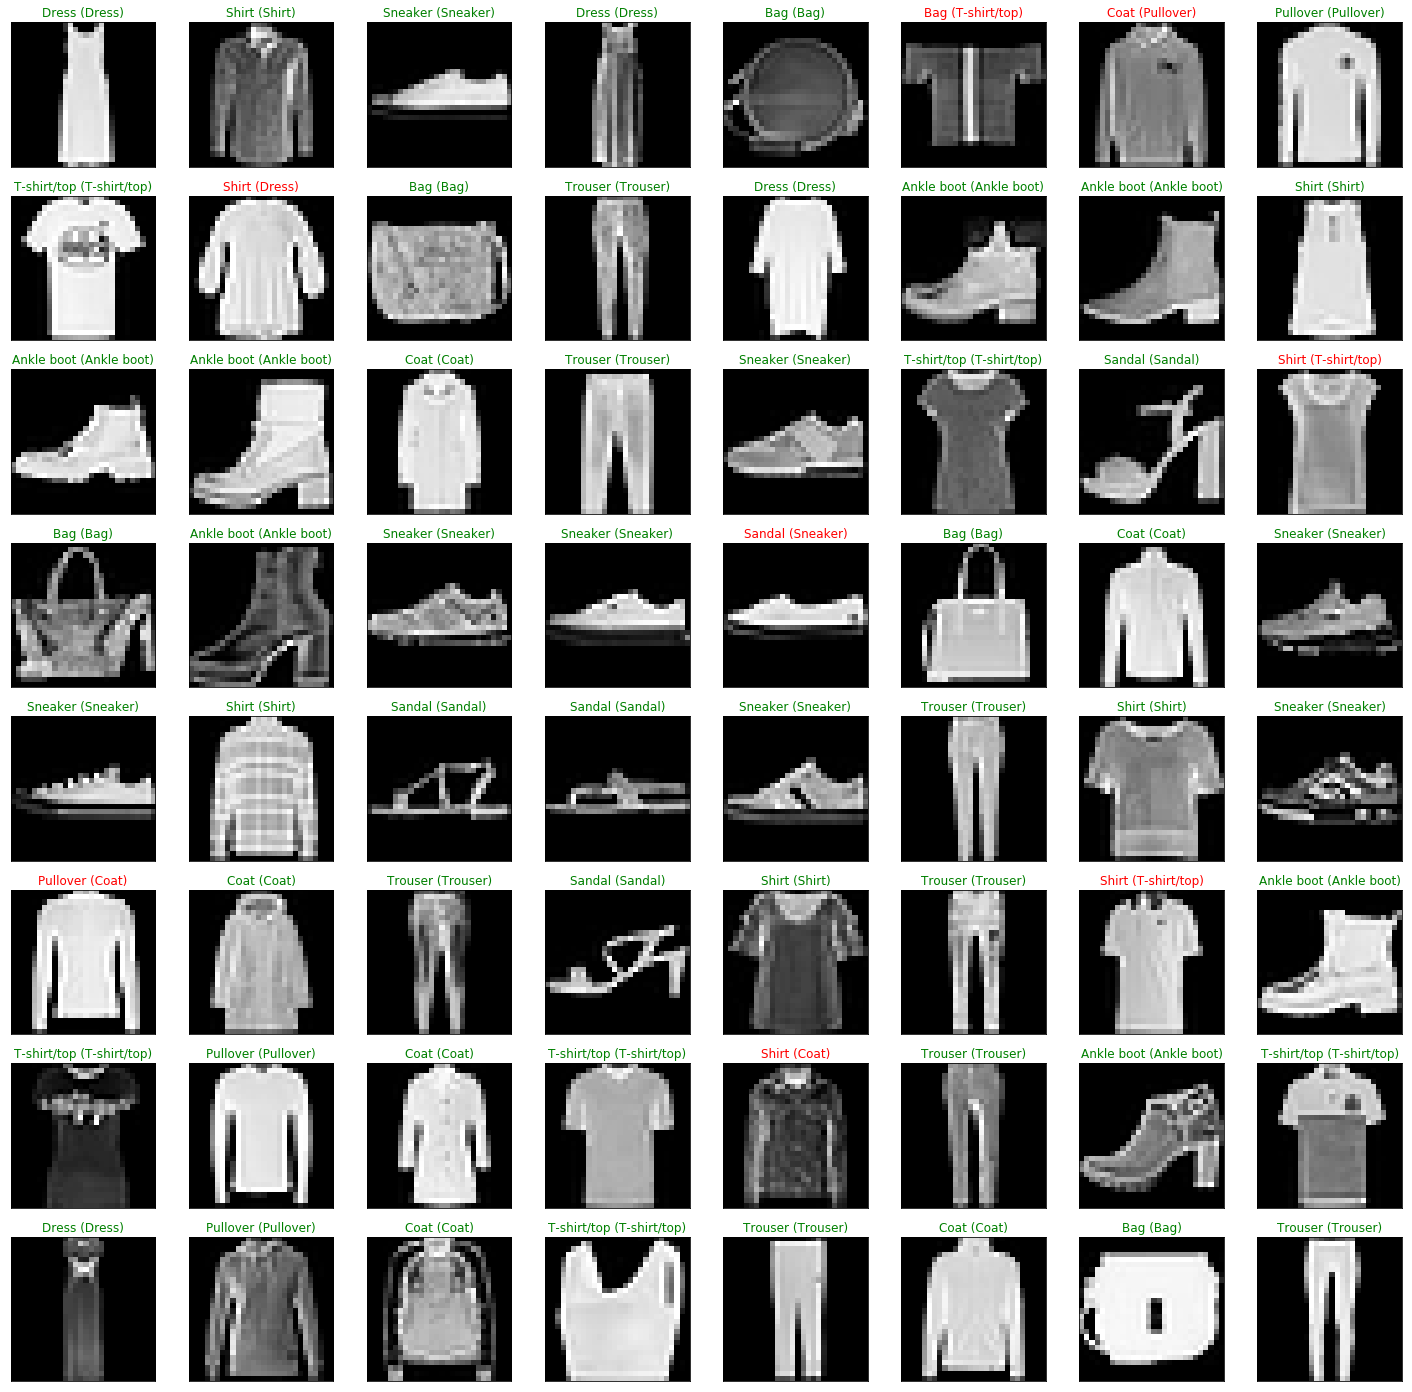

In [240]:
# obtain one batch of test images
net.cpu()
dataiter = iter(test_loader)
images, labels = dataiter.next()
# get predictions
with torch.no_grad():
    preds = np.squeeze(net(Variable(images)).data.max(1, keepdim=True)[1].numpy())
    images = images.numpy()

    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(25, 25))
    for idx in np.arange(batch_size):
        ax = fig.add_subplot(8, batch_size/8, idx+1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(images[idx]), cmap='gray')
        ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                     color=("green" if preds[idx]==labels[idx] else "red"))

In [233]:
checkpoint = {'input_size': 1,
              'output_size': 10,
              'conv_layers': [64,128],
              'fc_layers': [512],
              'state_dict': net.state_dict()}
torch.save(checkpoint, 'checkpoint.pth')

In [234]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = Net(checkpoint['input_size'],
                    checkpoint['output_size'],
                    checkpoint['conv_layers'],
                    checkpoint['fc_layers'],0.5)
    model.load_state_dict(checkpoint['state_dict'])
    
    return model

In [235]:
model = load_checkpoint('checkpoint.pth')
print(model)

Net(
  (conv_layers): ModuleList(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  )
  (bn_layers): ModuleList(
    (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5)
  (fc): Linear(in_features=3200, out_features=512, bias=True)
  (output): Linear(in_features=512, out_features=10, bias=True)
)
